In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Loading the data

In [2]:
anime_data = pd.read_csv("../Data/anime-list.csv")
anime_data.head()

,Unnamed: 0,name,studio,theme,tags,source,rating,year,synopsis,demographic,status,eps,eps_avg_duration_in_min,rated_by
0,0,Shingeki no Kyojin,Wit Studio,"Gore, Military, Survival","Action, Drama",Manga,8.53,2013.0,"Centuries ago, mankind was slaughtered to near...",Shounen,Finished,25.0,24.0,3.4M
1,1,Death Note,Madhouse,Psychological,"Supernatural, Suspense",Manga,8.63,2006.0,"Brutal murders, petty thefts, and senseless vi...",Shounen,Finished,37.0,23.0,3.4M
2,2,Fullmetal Alchemist: Brotherhood,Bones,Military,"Action, Adventure, Drama, Fantasy",Manga,9.14,2009.0,After a horrific alchemy experiment goes wrong...,Shounen,Finished,64.0,24.0,2.9M
3,3,Boku no Hero Academia,Bones,"School, Super Power",Action,Manga,7.95,2016.0,"The appearance of ""quirks,"" newly discovered s...",Shounen,Finished,13.0,24.0,2.6M
4,4,Naruto,Studio Pierrot,Martial Arts,"Action, Adventure, Fantasy",Manga,7.97,2002.0,"Moments prior to Naruto Uzumaki's birth, a hug...",Shounen,Finished,220.0,23.0,2.5M


In [3]:
anime_data.drop('Unnamed: 0',axis=1, inplace=True)

# General overview of the dataset

In [4]:
anime_data.describe()

,rating,year,eps,eps_avg_duration_in_min
count,1812.000000,2949.000000,2890.000000,2950.000000
mean,7.043311,2007.264157,43.062284,18.194576
std,0.776097,12.151285,75.149153,8.019819
min,2.930000,1963.000000,2.000000,0.000000
25%,6.490000,2002.000000,13.000000,12.000000
50%,7.050000,2011.000000,26.000000,23.000000
75%,7.550000,2016.000000,51.000000,24.000000
max,9.140000,2023.000000,1787.000000,50.000000


In [5]:
anime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3005 entries, 0 to 3004
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   name                     3005 non-null   object 
 1   studio                   3005 non-null   object 
 2   theme                    3005 non-null   object 
 3   tags                     2470 non-null   object 
 4   source                   2510 non-null   object 
 5   rating                   1812 non-null   float64
 6   year                     2949 non-null   float64
 7   synopsis                 2315 non-null   object 
 8   demographic              3005 non-null   object 
 9   status                   2981 non-null   object 
 10  eps                      2890 non-null   float64
 11  eps_avg_duration_in_min  2950 non-null   float64
 12  rated_by                 3005 non-null   object 
dtypes: float64(4), object(9)
memory usage: 305.3+ KB


# Evaluating NaN values

### Counting NaN values

In [6]:
missing_count = anime_data.isna().sum()
total_missing = missing_count.sum()

print(f"The dataframe has {total_missing} cells with NaN value")
missing_count

The dataframe has 3163 cells with NaN value


name                          0
studio                        0
theme                         0
tags                        535
source                      495
rating                     1193
year                         56
synopsis                    690
demographic                   0
status                       24
eps                         115
eps_avg_duration_in_min      55
rated_by                      0
dtype: int64

### Calculating the percentage

In [7]:
total_cells = np.product(anime_data.shape)

missing_percentage = (total_missing / total_cells) * 100
print(f"There is an amount of {missing_percentage}% missing values")

There is an amount of 8.096761807244336% missing values


## Filling NaN cells
1. Handling numerical values
---
A `random value` will be generated based on the `maximum` and `minimum` values of each numerical column as a `placeholder`<br> for NaN values.<br>
Then if the given column must hold `int` values then a casting will be made.

In [8]:
# Retrieving the columns that hold numerical values
numerical_cols = list(
    filter(lambda column: 
               anime_data[column].dtype == 'float64' or anime_data[column].dtype == 'int32', 
           anime_data.columns
          ))

for column in numerical_cols:
    column = str(column).strip()

numerical_cols

['rating', 'year', 'eps', 'eps_avg_duration_in_min']

In [9]:
np.random.seed(16)

for column in numerical_cols:
    minimum = anime_data[column].min()
    maximum = anime_data[column].max()
    
    if column != "rating":
        minimum = int(minimum)
        maximum = int(maximum)
    
    placeholder = np.random.choice(np.random.randint(minimum, maximum, size=(1)))
    
    anime_data[column].fillna(placeholder, inplace=True)
    
    if column != "rating":
        anime_data[column] = anime_data[column].astype(int)

2. Handling non numerical values
- 2.1 Retrieving the number of rates and converting them to int type

In [10]:
units = [value[-1] for value in anime_data.rated_by.values]
set(units)

{'0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'K', 'M'}

The highest value is the million

In [11]:
def fix_zeros(value:str,symbol:str,zeros_count:int):
    copy = value.replace(symbol,"")
    value = value.replace(".","")
    dot_index = copy.index(".") if "." in copy else 0
    
    # if there is no dot in the value
    if dot_index <= 0:
        return value.replace(symbol, "0" * (zeros_count - len(copy) + 1))

    else:
        after_dot_digits = len(copy[dot_index+1:])
        return value.replace(symbol, "0" * (zeros_count - after_dot_digits))

In [12]:
k_mask = anime_data.rated_by.str.contains("K")
m_mask = anime_data.rated_by.str.contains("M")

In [13]:
k_values_copy = anime_data.loc[k_mask, "rated_by"].copy()
m_values_copy = anime_data.loc[m_mask, "rated_by"].copy()

In [14]:
anime_data.loc[k_mask, "rated_by"] = k_values_copy.map(lambda value: fix_zeros(str(value).strip(),"K",3))

In [15]:
anime_data.loc[m_mask, "rated_by"] = m_values_copy.map(lambda value: fix_zeros(str(value).strip(),"M",6))

In [16]:
# Converting ratings count to integer type
anime_data.rated_by = anime_data.rated_by.astype(int)

- 2.2 Filling non numerical columns NaN cells

In [17]:
for column in anime_data.columns:
    if column not in numerical_cols:
        anime_data[column].fillna("unknown",inplace=True)

In [18]:
anime_data.isna().sum()

name                       0
studio                     0
theme                      0
tags                       0
source                     0
rating                     0
year                       0
synopsis                   0
demographic                0
status                     0
eps                        0
eps_avg_duration_in_min    0
rated_by                   0
dtype: int64

# DataFrame normalization
---
1. Theme and tags columns text normalization<br>
Each value from the `name`, `tags` and `theme` columns will be lowercased.<br>By doing so, when each of these values will be retrieved in a given `set`, it will be easier to create their respectif DataFrame and then do some `feature encoding`.
After feature encoding, the `anime_data` DataFrame will be linked to tags and theme DataFrames.

In [19]:
def lower_case_value(*columns):
    for column in columns:
        anime_data[column] = anime_data[column].map(lambda value: str(value).lower())        

In [20]:
lower_case_value("tags","theme","name")

In [21]:
anime_data[["name","tags","theme"]].head()

,name,tags,theme
0,shingeki no kyojin,"action, drama","gore, military, survival"
1,death note,"supernatural, suspense",psychological
2,fullmetal alchemist: brotherhood,"action, adventure, drama, fantasy",military
3,boku no hero academia,action,"school, super power"
4,naruto,"action, adventure, fantasy",martial arts


2. Extracting values from `tags` and `theme` columns

In [22]:
def extract_cell_value(column_name:str) -> set:
    """
    For a given column with string values separated by a comma, 
    each cell value(s) will be retrieved and then returned as a set.
    """
    result = set()
    column = anime_data[column_name].astype(str)
    
    for cell in column:
        for value in cell.split(","):
            result.add(str(value).strip())
            
    return result

In [23]:
tags_set = extract_cell_value("tags")
themes_set = extract_cell_value("theme")

3. Creating a DataFrame for tags and theme

In [24]:
tags_data = pd.DataFrame(index=anime_data.name, columns=tags_set)
theme_data = pd.DataFrame(index=anime_data.name, columns=themes_set)

In [25]:
anime_data.head()

,name,studio,theme,tags,source,rating,year,synopsis,demographic,status,eps,eps_avg_duration_in_min,rated_by
0,shingeki no kyojin,Wit Studio,"gore, military, survival","action, drama",Manga,8.53,2013,"Centuries ago, mankind was slaughtered to near...",Shounen,Finished,25,24,3400000
1,death note,Madhouse,psychological,"supernatural, suspense",Manga,8.63,2006,"Brutal murders, petty thefts, and senseless vi...",Shounen,Finished,37,23,3400000
2,fullmetal alchemist: brotherhood,Bones,military,"action, adventure, drama, fantasy",Manga,9.14,2009,After a horrific alchemy experiment goes wrong...,Shounen,Finished,64,24,2900000
3,boku no hero academia,Bones,"school, super power",action,Manga,7.95,2016,"The appearance of ""quirks,"" newly discovered s...",Shounen,Finished,13,24,2600000
4,naruto,Studio Pierrot,martial arts,"action, adventure, fantasy",Manga,7.97,2002,"Moments prior to Naruto Uzumaki's birth, a hug...",Shounen,Finished,220,23,2500000


In [26]:
tags_data.head()

,avant,gourmet,supernatural,horror,boys,mystery,romance,garde,action,drama,...,sports,ecchi,suspense,unknown,adventure,comedy,slice,life,sci-fi,girls
name,,,,,,,,,,,,,,,,,,,,,
shingeki no kyojin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
death note,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fullmetal alchemist: brotherhood,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
boku no hero academia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
naruto,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


4. Feature encoding
---
For a given anime, if it has a given `tag` or `theme` then the cell's value will be set to `1`. Otherwise it'll be `0`.

In [27]:
def encode_dataframe(column_name:str,frame:pd.DataFrame) -> None:
    # for each anime's data
    for line in anime_data[["name",column_name]].values:
        anime_tags = [str(value).strip() for value in line[1].split(",")]

        # for each tag or frame
        for column in frame.columns:
            if column in anime_tags:
                frame.loc[line[0],column] = 1
            else:
                 frame.loc[line[0],column] = 0

In [28]:
encode_dataframe("tags",tags_data)
tags_data.head()

,avant,gourmet,supernatural,horror,boys,mystery,romance,garde,action,drama,...,sports,ecchi,suspense,unknown,adventure,comedy,slice,life,sci-fi,girls
name,,,,,,,,,,,,,,,,,,,,,
shingeki no kyojin,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
death note,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
fullmetal alchemist: brotherhood,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,1,0,0,0,0,0
boku no hero academia,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
naruto,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


In [29]:
encode_dataframe("theme",theme_data)
theme_data.head()

,adult cast,gore,racing,visual arts,cgdct,mecha,martial arts,parody,vampire,gag humor,...,detective,video game,anthropomorphic,psychological,shounen,workplace,shoujo,music,seinen,time travel
name,,,,,,,,,,,,,,,,,,,,,
shingeki no kyojin,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
death note,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
fullmetal alchemist: brotherhood,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
boku no hero academia,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
naruto,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
theme_data.loc["shingeki no kyojin"].value_counts()

0    52
1     3
Name: shingeki no kyojin, dtype: int64

- Renaming DataFrames axis 

In [31]:
anime_data.rename_axis("anime_id",axis="rows", inplace=True)
anime_data.rename_axis("features", axis="columns", inplace=True)

tags_data.rename_axis("Tags", axis="columns", inplace=True)
theme_data.rename_axis("Themes", axis="columns", inplace=True)

From `tags_data` or `theme_data` DataFrame there is a link to `anime_data` DataFrame which is the `name` index.
Thus the `theme` and `tags` columns can be dropped from the `anime_data` DataFrame for creating a normalized data set.

In [32]:
anime_data.drop(["tags","theme"], axis=1,inplace=True)

### Correcting the "slice of life" tag that has been splitted into three columns

In [33]:
# Checking if every row having at least one this tag's words have the two others
tags_data.loc[:,["slice",'of','life']].sum()

Tags
slice    376
of       376
life     376
dtype: object

See that the hypothesis is verified, then the "slice of life" column can be created

In [34]:
tags_data["slice of life"] = 0

for index in tags_data.index:
    if tags_data.loc[index, "slice"] == 1:
        tags_data.loc[index, "slice of life"] = 1

In [35]:
tags_data.drop(["slice","of","life"],axis=1,inplace=True)

In [36]:
set(tags_data.columns)

{'action',
 'adventure',
 'avant',
 'boys',
 'comedy',
 'drama',
 'ecchi',
 'fantasy',
 'garde',
 'girls',
 'gourmet',
 'horror',
 'love',
 'mystery',
 'romance',
 'sci-fi',
 'slice of life',
 'sports',
 'supernatural',
 'suspense',
 'unknown'}

In [37]:
set(theme_data.columns)

{'adult cast',
 'anthropomorphic',
 'cgdct',
 'childcare',
 'combat sports',
 'crossdressing',
 'delinquents',
 'detective',
 'educational',
 'gag humor',
 'gore',
 'harem',
 'high stakes game',
 'historical',
 'idols (female)',
 'idols (male)',
 'isekai',
 'iyashikei',
 'josei',
 'kids',
 'love polygon',
 'magical sex shift',
 'mahou shoujo',
 'martial arts',
 'mecha',
 'medical',
 'military',
 'music',
 'mythology',
 'organized crime',
 'otaku culture',
 'parody',
 'performing arts',
 'pets',
 'psychological',
 'racing',
 'reincarnation',
 'reverse harem',
 'romantic subtext',
 'samurai',
 'school',
 'seinen',
 'shoujo',
 'shounen',
 'showbiz',
 'space',
 'strategy game',
 'super power',
 'survival',
 'team sports',
 'time travel',
 'vampire',
 'video game',
 'visual arts',
 'workplace'}

# Data description through visualization

In [38]:
tags = tags_data.sum()
themes = theme_data.sum()

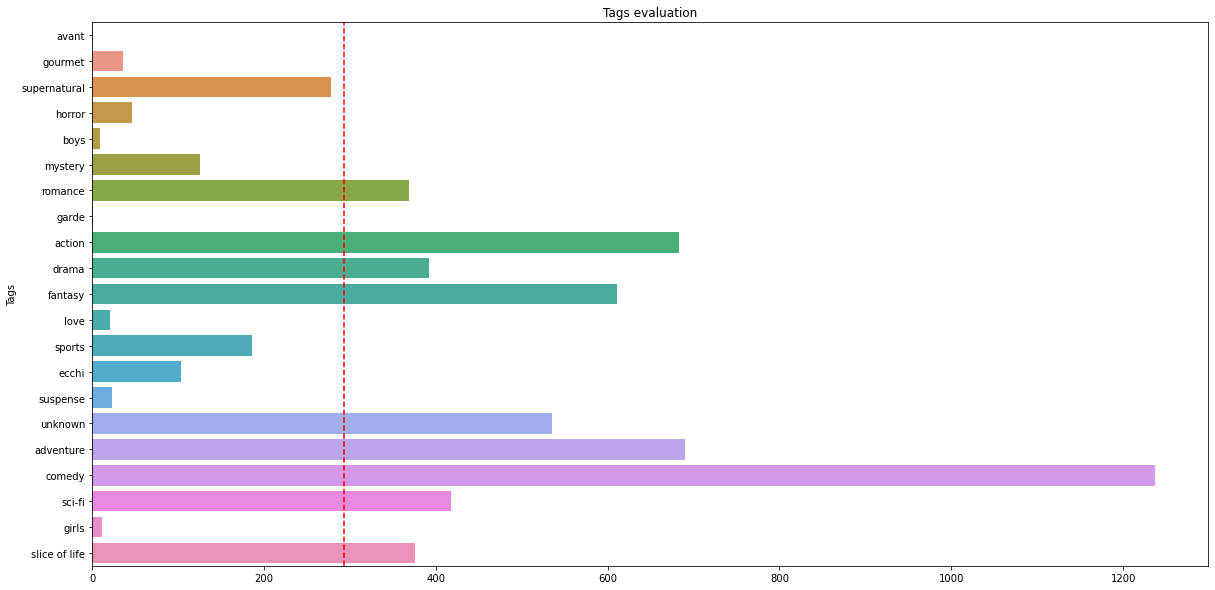

In [39]:
plt.figure(figsize=(20,10))
plt.title("Tags evaluation")
graph = sns.barplot(x=tags.values, y=tags.index,orient="h")

tags_mean = tags.mean()
graph.axes.axvline(tags_mean, ls="--", color="red", label="mean")

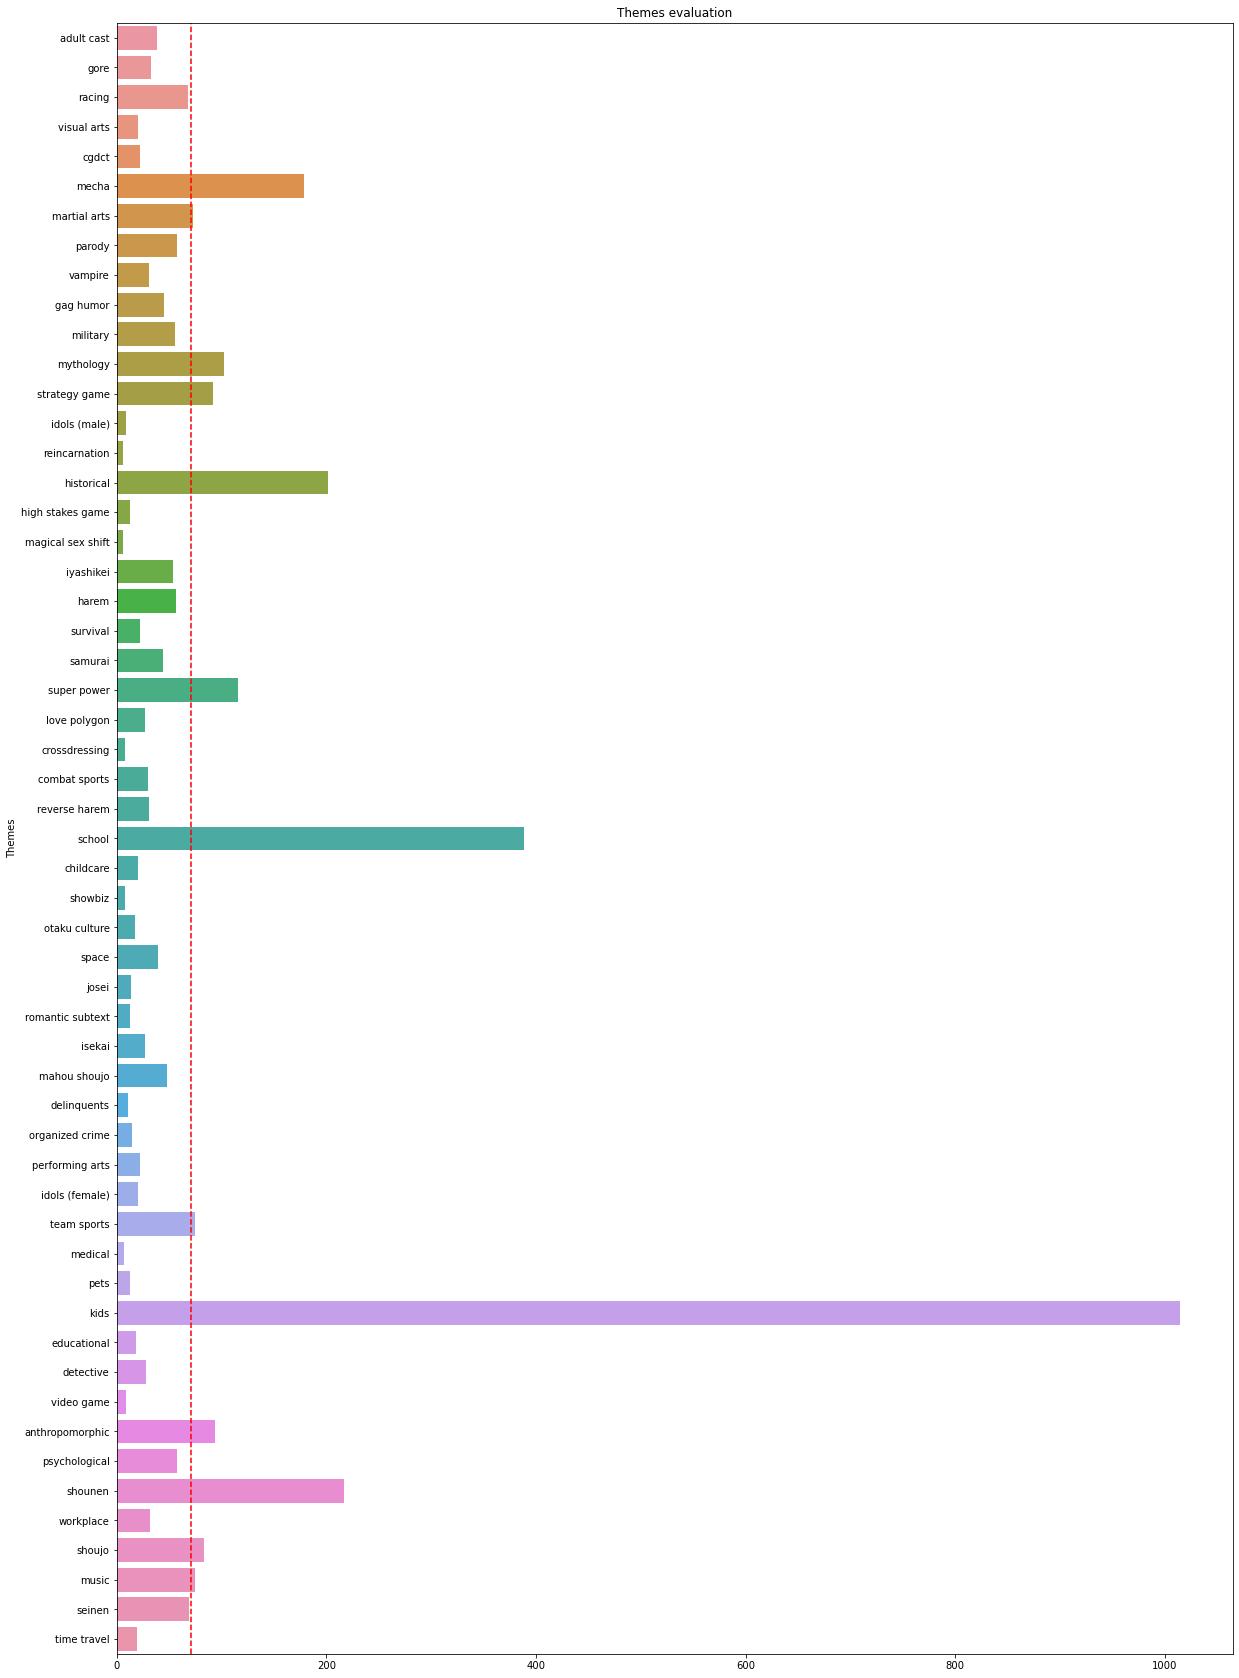

In [40]:
plt.figure(figsize=(20,30))
plt.title("Themes evaluation")
graph = sns.barplot(x=themes.values, y=themes.index,orient="h")

themes_mean = themes.mean()
graph.axes.axvline(themes_mean, ls="--", c="red")

In [41]:
under_average_themes =  [{"theme":theme, "count":theme_count} for theme, theme_count in zip(themes.index, themes.values) if theme_count < themes_mean]
under_average_themes[:5]

[{'theme': 'adult cast', 'count': 38},
 {'theme': 'gore', 'count': 33},
 {'theme': 'racing', 'count': 68},
 {'theme': 'visual arts', 'count': 20},
 {'theme': 'cgdct', 'count': 22}]

In [42]:
average_themes = [{"theme":theme, "count":theme_count} for theme, theme_count in zip(themes.index, themes.values) if theme_count >= themes_mean]
average_themes[:5]

[{'theme': 'mecha', 'count': 179},
 {'theme': 'martial arts', 'count': 73},
 {'theme': 'mythology', 'count': 102},
 {'theme': 'strategy game', 'count': 92},
 {'theme': 'historical', 'count': 202}]

In [43]:
tags_under_mean = [{"tag":tag, "count":tag_count} for tag, tag_count in zip(tags.index, tags.values) if tag_count < tags_mean]
tags_under_mean[:5]

[{'tag': 'avant', 'count': 1},
 {'tag': 'gourmet', 'count': 36},
 {'tag': 'supernatural', 'count': 278},
 {'tag': 'horror', 'count': 47},
 {'tag': 'boys', 'count': 9}]

In [44]:
average_tags = [{"tag":tag, "count":tag_count} for tag, tag_count in zip(tags.index, tags.values) if tag_count >= tags_mean]
average_tags[:5]

[{'tag': 'romance', 'count': 369},
 {'tag': 'action', 'count': 683},
 {'tag': 'drama', 'count': 392},
 {'tag': 'fantasy', 'count': 611},
 {'tag': 'unknown', 'count': 535}]

<AxesSubplot:title={'center':'Tags comparison'}, xlabel='Tag category', ylabel='Value count'>

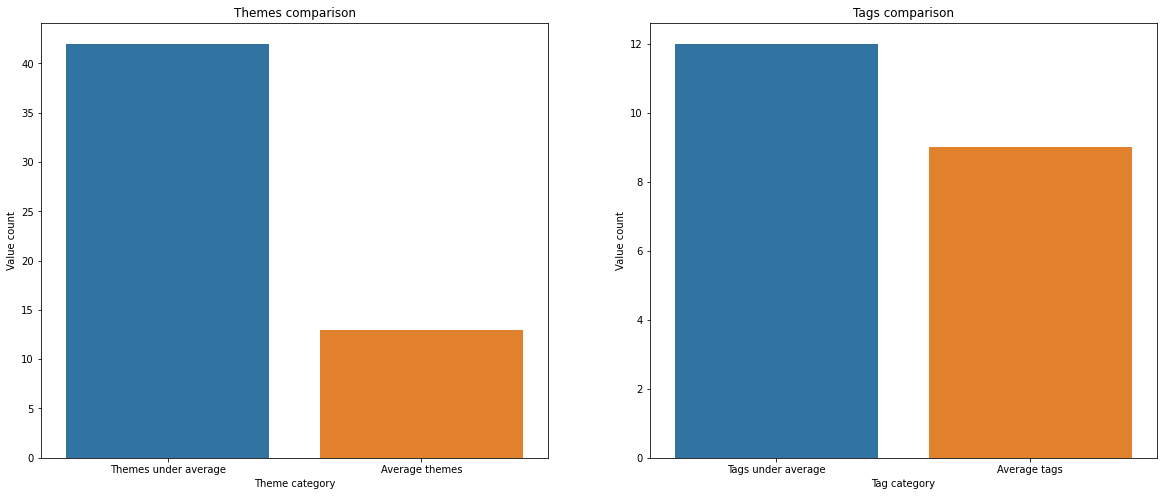

In [45]:
fig, ax = plt.subplots(1,2, figsize=(20,8))

ax[0].set_title("Themes comparison")
ax[0].set_xlabel("Theme category")
ax[0].set_ylabel("Value count")

ax[1].set_title("Tags comparison")
ax[1].set_xlabel("Tag category")
ax[1].set_ylabel("Value count")

sns.barplot(ax=ax[0], x=["Themes under average", "Average themes"], y=[len(under_average_themes), len(average_themes)])
sns.barplot(ax=ax[1], x=["Tags under average", "Average tags"], y=[len(tags_under_mean), len(average_tags)])

- There are some themes that are less used in animes
- Animes have some tags that are less used. Nonetheless, the difference is more or less neglectable
- We can seek if there's a relation between theses results and animes ratings
- There are more animes with the `comedy` tag and those having the `kids` theme too.
- It could be a good idea to make a `comic` anime which main theme is `kids` to reach a larger public see that they are most used `tag` and `theme`
- Let's see if these are `the most popular` animes

In [46]:
# correcting the status column in the main DataFrame
# some cells have "Not" or "ished" as value instead of "Not finished"
for index in anime_data.index:
    if anime_data.loc[index,"status"] == "Not" or anime_data.loc[index,"status"] == "Ished" or anime_data.loc[index,"status"] == "ished":
        anime_data.loc[index,"status"] = "Not finished"

## Ratings visualization

In [62]:
ratings_mean = anime_data.rating.mean()
raters_mean = anime_data.rated_by.mean()
ratings_mean, raters_mean

(5.438096505823619, 36614.37104825291)

In [48]:
kids_or_comedy_anime = []
not_kid_or_comedy_anime = []

## Plot comparison if kids theme or comedy tag

1.) Rating by demographic, status and source

<AxesSubplot:xlabel='status', ylabel='rating'>

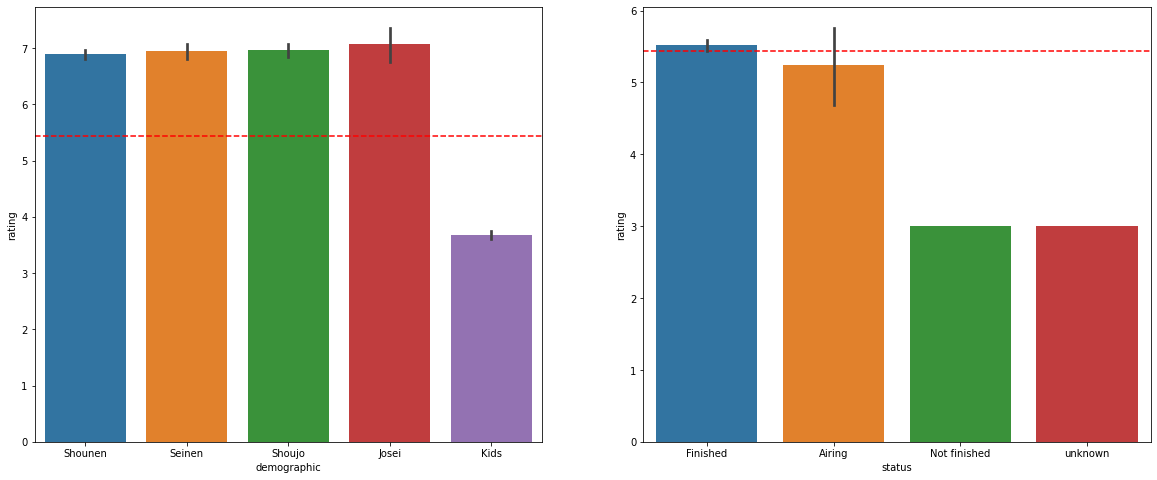

In [49]:
fig, ax = plt.subplots(1,2, figsize=(20,8))

for i in range(2):
    ax[i].axhline(ratings_mean, ls="--", color="r")

sns.barplot(ax=ax[0], x=anime_data.demographic, y=anime_data.rating)
sns.barplot(ax=ax[1], x=anime_data.status, y=anime_data.rating)

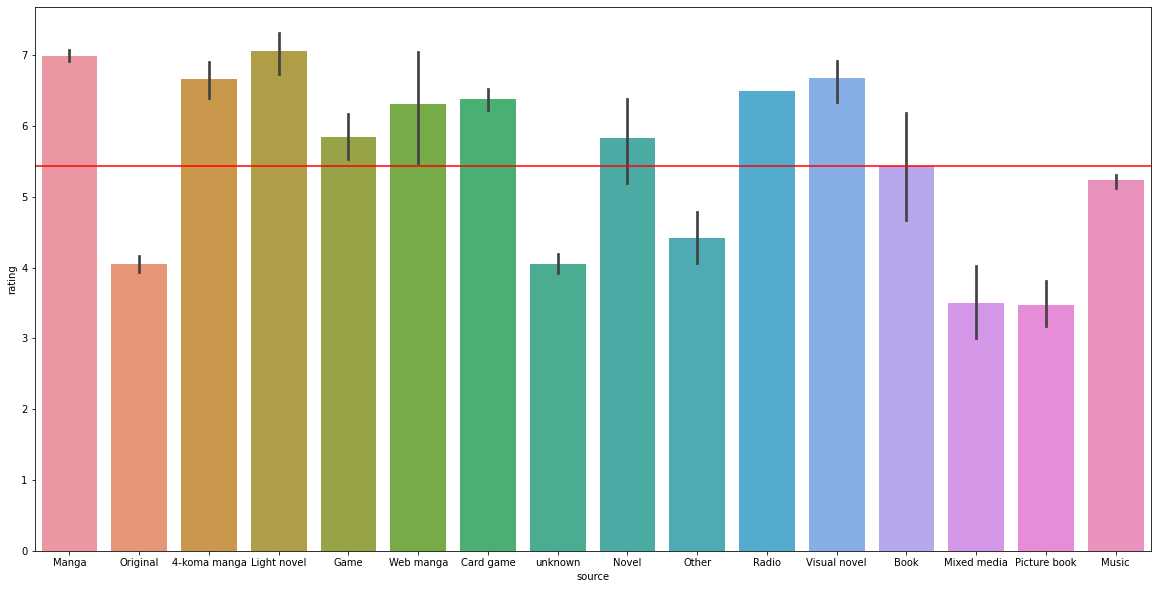

In [50]:
plt.figure(figsize=(20,10))
graph = sns.barplot(x=anime_data.source, y=anime_data.rating)
graph.axes.axhline(ratings_mean, c="r")

- `Finished` animes have the highest rates. After them, comes the airing ones. Those that are not finished are less popular, they are even under the average on ratings
- Animes with `kids` demographic don't have a good rating
- And based on the anime's `source` it tends to be more or less popular

2.) Rating by source with a demographic hue and status hue

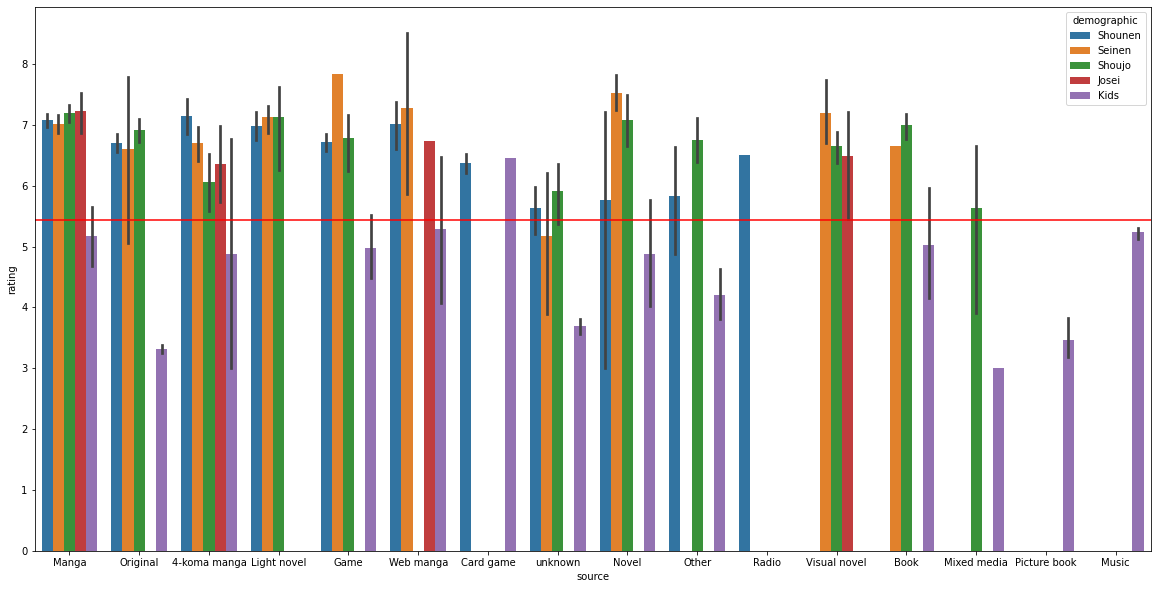

In [51]:
plt.figure(figsize=(20,10))
graph = sns.barplot(x=anime_data.source, y=anime_data.rating, hue=anime_data.demographic)
graph.axes.axhline(ratings_mean, c="r")

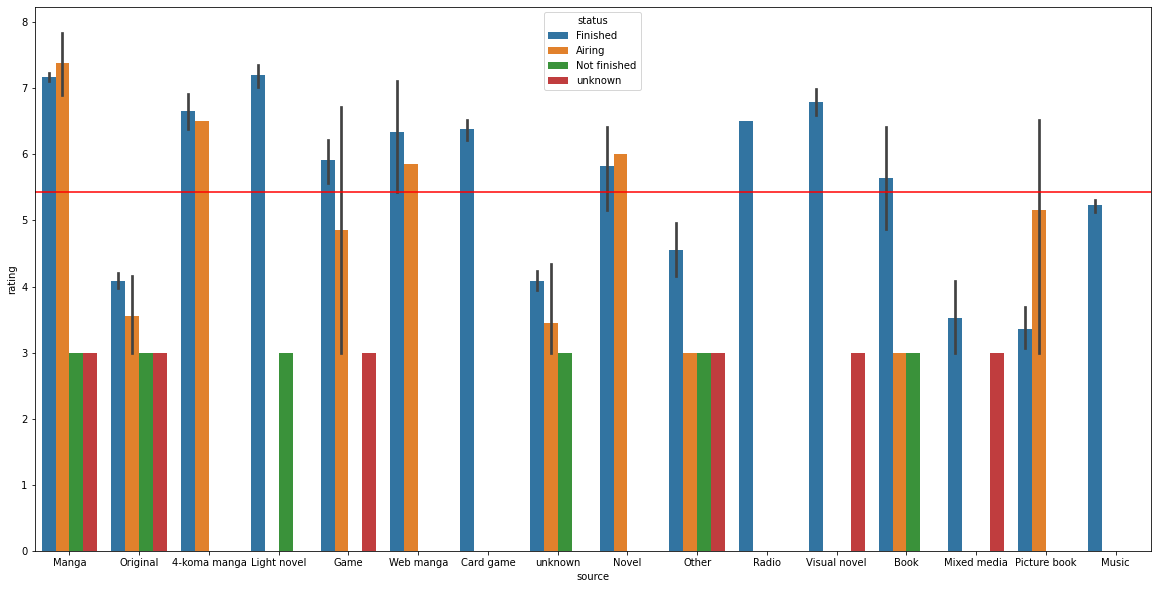

In [52]:
plt.figure(figsize=(20,10))
graph = sns.barplot(x=anime_data.source, y=anime_data.rating, hue=anime_data.status)
graph.axes.axhline(ratings_mean, c="r")

- For each source, the `kids` demographic is the least popular
- When the anime is provided as `a ressource to read` it tends be more popular when it's airing otherwise, the `finished` ones are more popular

3.) Rating by the number of people who 

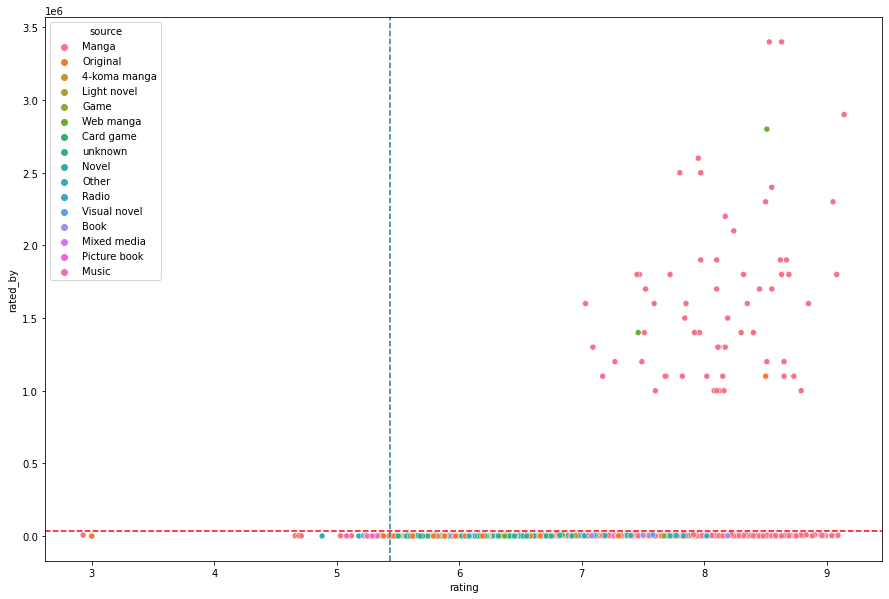

In [65]:
plt.figure(figsize=(15,10))
graph = sns.scatterplot(data=anime_data,x='rating', y='rated_by',hue='source')

graph.axes.axvline(ratings_mean, ls="--")
graph.axes.axhline(raters_mean, ls="--", c="r")

We can see that most raters are `manga` readers. Thus mangas are the most loved products.